# 1. Wikidump downloading files

Notebook for downloading wikidumps.

In [1]:
#Required Imports

import os
import requests
from bs4 import BeautifulSoup
import wget # (to download wikidump files!)
import pathlib

## IMPORT PARAMETERS

In [2]:
# wikidump base urls.
english_wikidump = 'https://dumps.wikimedia.org/enwiki/'
french_wikidump = 'https://dumps.wikimedia.org/frwiki/'
dutch_wikidump = 'https://dumps.wikimedia.org/nlwiki/'

# Change based on which language and backup you want to download!
base_url = english_wikidump
dump_url = base_url + '20220420/'

In [3]:
# Retrieve the html
dump_html = requests.get(dump_url).text

# Convert to a soup
soup_dump = BeautifulSoup(dump_html, 'html.parser')

## Find Correct Files

In [4]:
files = []

# Search through all files
for file in soup_dump.find_all('li', {'class': 'file'}):
    url = 'https://dumps.wikimedia.org' + file.a['href']
    text = file.text
    
    # Select the relevant files
    if 'pages-articles-multistream' in text and '.xml-p' in text:
        files.append((url, text.split()[0], float(text.split()[1:][0])))
        
files[0]

('https://dumps.wikimedia.org/enwiki/20220420/enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2',
 'enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2',
 247.4)

## Download Files

In [5]:
data_paths, file_info = [], []

subfolder = base_url.split('/')[-2]
datasets_directory =  f'../../../{subfolder}/' # f'../input/wikidump/{subfolder}/' 


if not os.path.exists(datasets_directory):
    pathlib.Path(datasets_directory).mkdir(parents=True, exist_ok=True)
    print(f'Created a new directory at {datasets_directory}.')
    
for url, name, size in files[:2]: # remove subsetting in order to download the full dump
    path = datasets_directory + name
    
    if not os.path.exists(path):
        pass
        # wget.download(url, out = path) #uncomment in order to actually download
    
    data_paths.append(path)
    
    # file_size = os.stat(path).st_size / 1e6
    file_articles = int(name.split('p')[-1].split('.')[-2]) - int(name.split('p')[-2])
    file_info.append((name, size, file_articles))

Created a new directory at ../../../enwiki/.


In [6]:
print(f'There are {len(file_info)} files.')

There are 2 files.


## Articles per file

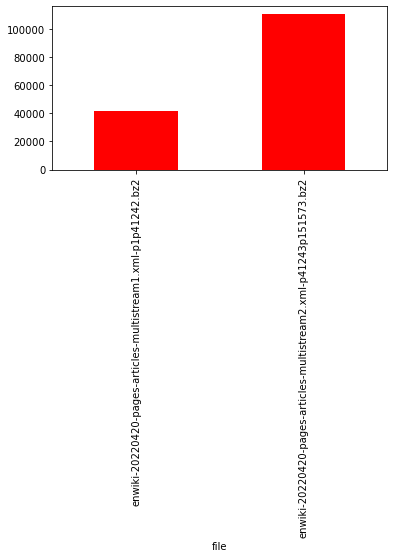

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['articles'].plot.bar(color = 'red', figsize = (6, 3));

In [8]:
print(f"The total size of files in directory: '{datasets_directory}' is {file_df['size (MB)'].sum() / 1e3} GB.")

The total size of files in directory: '../../../enwiki/' is 0.5792 GB.


# 2. Parsing Data

In [20]:
import sys
import bz2   # is slower than subproces & bzcat!
# import subproces
import xml.sax

In [22]:
lines = []

for i, line in enumerate(bz2.BZ2File(data_paths[0], 'r')):
    lines.append(line)
    if i > 5e5:
        break
        
lines[0:150]

[b'<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">\n',
 b'  <siteinfo>\n',
 b'    <sitename>Wikipedia</sitename>\n',
 b'    <dbname>enwiki</dbname>\n',
 b'    <base>https://en.wikipedia.org/wiki/Main_Page</base>\n',
 b'    <generator>MediaWiki 1.39.0-wmf.7</generator>\n',
 b'    <case>first-letter</case>\n',
 b'    <namespaces>\n',
 b'      <namespace key="-2" case="first-letter">Media</namespace>\n',
 b'      <namespace key="-1" case="first-letter">Special</namespace>\n',
 b'      <namespace key="0" case="first-letter" />\n',
 b'      <namespace key="1" case="first-letter">Talk</namespace>\n',
 b'      <namespace key="2" case="first-letter">User</namespace>\n',
 b'      <namespace key="3" case="first-letter">User talk</namespace>\n',
 b'      <namespace key="4" case="first-letter">Wi

In [11]:
# b'{{see also|Glossary of anarchism}}\n',
# ''an-'' (&quot;without&quot;)
# [[society|societies]]
# {{sfnm|1a1=Merriam-Webster|1y=2019|1loc=&quot;Anarchism&quot;|2a1=''Oxford English Dictionary''|2y=2005|2loc=&quot;Anarchism&quot;|3a1=Sylvan|3y=2007|3p=260}}

In [12]:
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Content handler for Wiki XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._pages.append((self._values['title'], self._values['text']))

In [19]:
# Content handler for Wiki XML
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for l in lines:
    parser.feed(l)
    
    if len(handler._pages) > 5:
        break
    
print([page[1] for page in handler._pages])

['#REDIRECT [[Computer accessibility]] \n \n {{rcat shell| \n {{R from move}} \n {{R from CamelCase}} \n {{R unprintworthy}} \n }}', '{{short description|Political philosophy and movement}} \n {{other uses}} \n {{redirect2|Anarchist|Anarchists|other uses|Anarchist (disambiguation)}} \n {{distinguish|Anarchy}} \n {{pp-semi-indef}} \n {{good article}} \n {{use British English|date=August 2021}} \n {{use dmy dates|date=August 2021}} \n {{anarchism sidebar}} \n {{basic forms of government}} \n \'\'\'Anarchism\'\'\' is a [[political philosophy]] and [[Political movement|movement]] that is sceptical of [[authority]] and rejects all involuntary, coercive forms of [[Social hierarchy|hierarchy]]. Anarchism calls for the abolition of the [[State (polity)|state]], which it holds to be unnecessary, undesirable, and harmful. As a historically [[left-wing]] movement, placed on the farthest left of the [[political spectrum]], it is usually described alongside [[Communalism (Bookchin)|communalism]] an

# Extract Text
Done with [wikiextractor](https://github.com/attardi/wikiextractor)  
wikiextractor doesn't properly work on Windows (so was done by Brecht on a Macbook)  

For the code in `analyses/Brecht` it is recommended to save the extracted files to directories named in the following pattern: `language`wikiextracted. e.g. `enwikiextracted` for English,

In [2]:
# https://github.com/attardi/wikiextractor/ Gives problems on Windows due to lacking fork, requires ubuntu or docker (https://stackoverflow.com/questions/70070505/wikipedia-extractor-problem-valueerror-cannot-find-context-for-fork)
# python -m wikiextractor.WikiExtractor <Wikipedia dump file> [--no-templates <extracted template file>] -o <output_path>

#enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2